In [8]:
import pandas as pd
import numpy as np
import glob # Used to find all the files matching a pattern
import os
from tqdm.auto import tqdm # For showing a progress bar

# --- Configuration ---
DATA_DIR = 'data' # The folder where you saved your data
PRICE_SHIFT = -10 # How many seconds into the future to predict the price
                  # A negative number means we look into the future

/Users/aravgupta/Documents/PredictiveCryptoBot/quant-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Find all the parquet files in the data directory
files = sorted(glob.glob(os.path.join(DATA_DIR, '*.parquet')))

# Read all files and combine them into a single DataFrame
df_list = []
for file in tqdm(files, desc="Loading data files"):
    try:
        df_list.append(pd.read_parquet(file))
    except Exception as e:
        print(f"Could not read file {file}: {e}")

raw_df = pd.concat(df_list, ignore_index=True)

# Set the timestamp as the index for easier time-series operations
raw_df.set_index('timestamp', inplace=True)

print(f"Loaded {len(raw_df)} snapshots.")
raw_df.head()

Loading data files: 100%|████████████████████████████████████████████████████████████████████████████████| 1207/1207 [00:02<00:00, 501.88it/s]


Loaded 1207 snapshots.


,order_book,trades
timestamp,,
2025-10-18 13:47:29.857072+00:00,"{'asks': [[106832.0, 4.09724], [106832.01, 0.0...","[{'amount': 0.00108, 'cost': 115.3947492, 'dat..."
2025-10-18 13:47:36.036002+00:00,"{'asks': [[106832.0, 0.31345], [106832.01, 0.0...","[{'amount': 5e-05, 'cost': 5.342, 'datetime': ..."
2025-10-18 13:47:41.397149+00:00,"{'asks': [[106832.0, 0.21276], [106832.01, 0.0...","[{'amount': 6e-05, 'cost': 6.410235, 'datetime..."
2025-10-18 13:47:46.760761+00:00,"{'asks': [[106851.84, 0.7091], [106851.85, 0.0...","[{'amount': 6e-05, 'cost': 6.40992, 'datetime'..."
2025-10-18 13:47:52.118733+00:00,"{'asks': [[106844.8, 8.35012], [106844.81, 0.0...","[{'amount': 0.00511, 'cost': 545.91152, 'datet..."


In [10]:
# These functions will process one row of the raw DataFrame at a time.

def calculate_mid_price(row):
    """Calculates the mid-price from the order book."""
    best_bid = row['order_book']['bids'][0][0] # Highest buy price
    best_ask = row['order_book']['asks'][0][0] # Lowest sell price
    return (best_bid + best_ask) / 2

def calculate_bid_ask_spread(row):
    """Calculates the difference between the best bid and best ask."""
    best_bid = row['order_book']['bids'][0][0]
    best_ask = row['order_book']['asks'][0][0]
    return best_ask - best_bid

def calculate_order_book_imbalance(row, depth=10):
    """
    Calculates the Order Book Imbalance (OBI).
    OBI = (Total Bid Volume) / (Total Bid Volume + Total Ask Volume)
    A value > 0.5 suggests buying pressure, < 0.5 suggests selling pressure.
    """
    bids_vol = sum([vol for price, vol in row['order_book']['bids'][:depth]])
    asks_vol = sum([vol for price, vol in row['order_book']['asks'][:depth]])
    total_vol = bids_vol + asks_vol
    return bids_vol / total_vol if total_vol > 0 else 0.5

def calculate_trade_flow(row, window=10):
    """
    Calculates the recent trade flow.
    Compares the volume of 'buy' vs 'sell' market orders in the last 'window' trades.
    Returns the total volume of buy trades minus the total volume of sell trades.
    """
    trade_list = row['trades']
    if not isinstance(trade_list, list) or len(trade_list) == 0:
        return 0

    # Ensure slicing works correctly
    trade_list = trade_list[:window]

    buys = sum([trade['amount'] for trade in trade_list if trade['side'] == 'buy'])
    sells = sum([trade['amount'] for trade in trade_list if trade['side'] == 'sell'])

    return buys - sells

In [12]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

tqdm.pandas(desc="Calculating Features (Optimized)")

# --- Configuration ---
PRICE_SHIFT = -10  # How many rows into the future to predict

# --- Create empty DataFrame for features ---
features_df = pd.DataFrame(index=raw_df.index)

# --- Mid-price and Spread ---
# Vectorized calculation: take first bid & ask from order book
features_df['mid_price'] = raw_df['order_book'].apply(lambda ob: (ob['bids'][0][0] + ob['asks'][0][0]) / 2)
features_df['spread'] = raw_df['order_book'].apply(lambda ob: ob['asks'][0][0] - ob['bids'][0][0])

# --- Order Book Imbalance (OBI) ---
def obi_vectorized(ob, depth=10):
    bids_vol = sum([vol for price, vol in ob['bids'][:depth]])
    asks_vol = sum([vol for price, vol in ob['asks'][:depth]])
    total = bids_vol + asks_vol
    return bids_vol / total if total > 0 else 0.5

features_df['obi'] = raw_df['order_book'].progress_apply(obi_vectorized)

# --- Trade Flow ---
def trade_flow_vectorized(trades, window=10):
    if not isinstance(trades, list) or len(trades) == 0:
        return 0
    trades = trades[:window]
    buys = sum([t.get('amount', 0) for t in trades if t.get('side') == 'buy'])
    sells = sum([t.get('amount', 0) for t in trades if t.get('side') == 'sell'])
    return buys - sells

features_df['trade_flow'] = raw_df['trades'].progress_apply(trade_flow_vectorized)

# --- Target Calculation ---
features_df['future_mid_price'] = features_df['mid_price'].shift(PRICE_SHIFT)
price_change_pct = (features_df['future_mid_price'] - features_df['mid_price']) / features_df['mid_price']

threshold = 0.0001  # 0.01%
features_df['target'] = 0
features_df.loc[price_change_pct > threshold, 'target'] = 1
features_df.loc[price_change_pct < -threshold, 'target'] = -1

# --- Clean up ---
final_df = features_df.dropna()
final_df['target'] = final_df['target'].astype(int)

# --- Save processed data ---
processed_data_path = 'processed_market_data.parquet'
final_df.to_parquet(processed_data_path)

print("Optimized feature calculation complete!")
print(f"Final dataset shape: {final_df.shape}")
print("\nTarget distribution:")
print(final_df['target'].value_counts())


Calculating Features (Optimized): 100%|███████████████████████████████████████████████████████████████| 1207/1207 [00:00<00:00, 733380.40it/s]

Optimized feature calculation complete!
Final dataset shape: (1197, 6)

Target distribution:
target
 1    430
-1    420
 0    347
Name: count, dtype: int64



/var/folders/6l/9wyl3y1x1_b6q0swtzrys8y80000gn/T/ipykernel_79401/747041622.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['target'] = final_df['target'].astype(int)


In [14]:
import pandas as pd
import xgboost as xgb
import joblib

# --- Configuration ---
PROCESSED_DATA_PATH = 'processed_market_data.parquet'
MODEL_SAVE_PATH = 'model.joblib'
TEST_SIZE = 0.2

# --- Load processed data ---
df = pd.read_parquet(PROCESSED_DATA_PATH)
X = df.drop(columns=['mid_price', 'future_mid_price', 'target'])
y = df['target']

# --- Time-series split ---
split_index = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- Map labels for 3-class classification ---
# {-1, 0, 1} -> {0, 1, 2}
y_train_mapped = y_train + 1

# --- Initialize XGBoost model (clean version, no warning) ---
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=3,                # Number of classes
    eval_metric='mlogloss',     # Evaluation metric
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# --- Train model ---
print("\nTraining XGBoost model...")
model.fit(X_train, y_train_mapped)
print("Model training complete.")

# --- Save model ---
joblib.dump(model, MODEL_SAVE_PATH)
print(f"\nModel saved to {MODEL_SAVE_PATH}")

# --- Optional: Test predictions ---
y_pred = model.predict(X_test)
print(f"\nSample predictions: {y_pred[:10]}")

Training data shape: (957, 3)
Testing data shape: (240, 3)

Training XGBoost model...
Model training complete.

Model saved to model.joblib

Sample predictions: [2 2 2 1 2 2 2 1 1 1]


In [2]:
print(df['target'].value_counts())

target
0    3
1    1
Name: count, dtype: int64


--- Performance Metrics ---
Sharpe Ratio: -12.98
Maximum Drawdown: -8.13%
Final Strategy PnL: $-809.25
Final Buy & Hold PnL: $-21.51


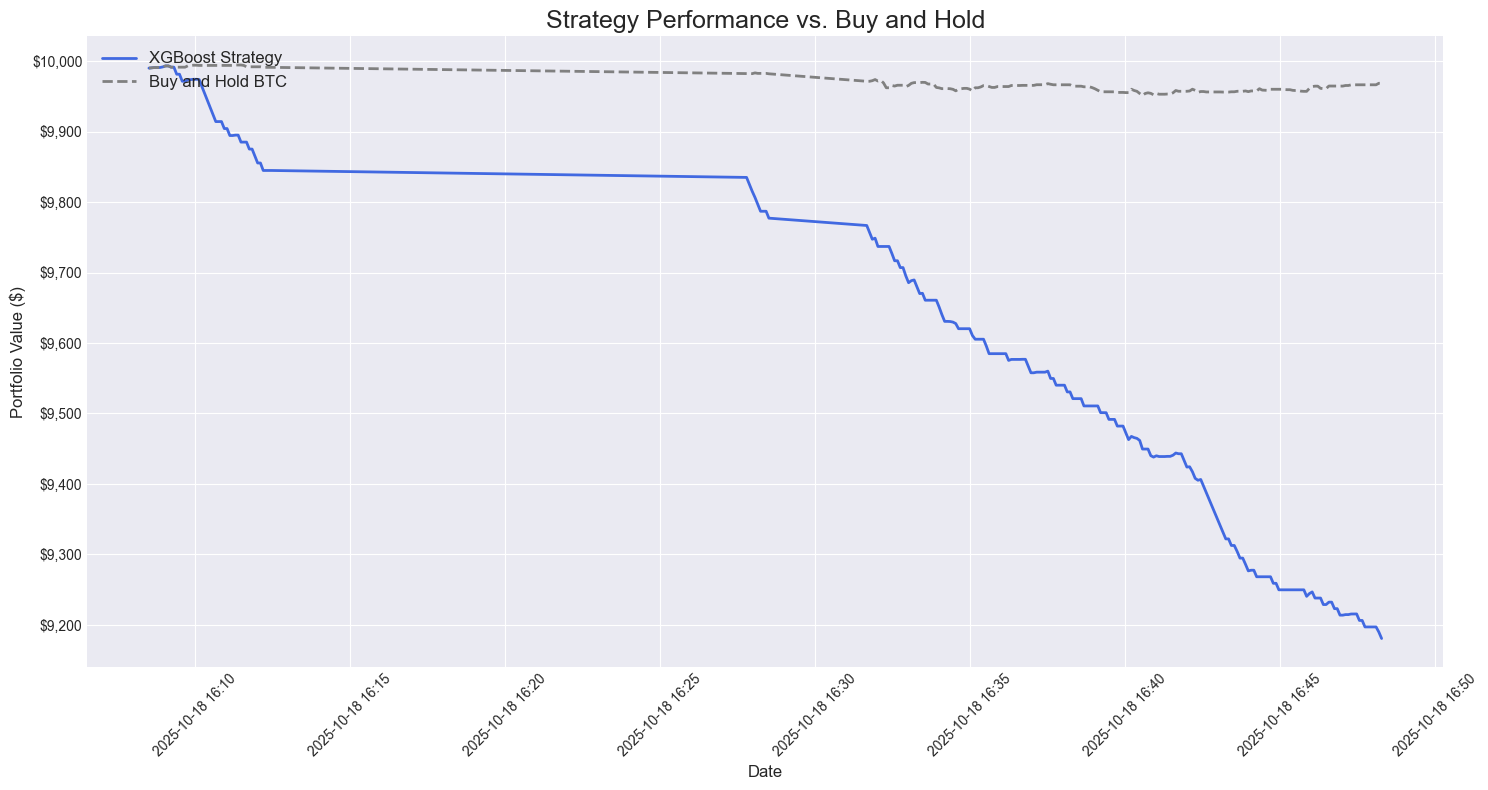

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Configuration ---
RESULTS_PATH = 'backtest_results.csv'
PROCESSED_DATA_PATH = 'processed_market_data.parquet'
TEST_SIZE = 0.2
RISK_FREE_RATE = 0.02 # Annual risk-free rate (e.g., 2% for T-bills), for Sharpe Ratio

# 1. Load the backtest results and the original data
results_df = pd.read_csv(RESULTS_PATH, parse_dates=['timestamp'])
results_df.set_index('timestamp', inplace=True)

# Isolate the test set price data for our "buy and hold" comparison
df = pd.read_parquet(PROCESSED_DATA_PATH)
split_index = int(len(df) * (1 - TEST_SIZE))
test_set_prices = df[split_index:].copy()


# 2. Calculate "Buy and Hold" strategy performance
initial_price = test_set_prices['mid_price'].iloc[0]
initial_capital = results_df['portfolio_value'].iloc[0]
buy_and_hold_values = (test_set_prices['mid_price'] / initial_price) * initial_capital

# --- Calculate Key Performance Metrics ---

# Calculate daily returns for both strategies
strategy_returns = results_df['portfolio_value'].pct_change().dropna()

# A. Sharpe Ratio (Risk-Adjusted Return)
# Assumes returns are daily, so we annualize
daily_risk_free_rate = (1 + RISK_FREE_RATE)**(1/365) - 1
excess_returns = strategy_returns - daily_risk_free_rate
sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) # Annualized

# B. Maximum Drawdown (Largest peak-to-trough drop)
cumulative_returns = (1 + strategy_returns).cumprod()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns / peak) - 1
max_drawdown = drawdown.min()

print("--- Performance Metrics ---")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Final Strategy PnL: ${results_df['portfolio_value'].iloc[-1] - initial_capital:,.2f}")
print(f"Final Buy & Hold PnL: ${buy_and_hold_values.iloc[-1] - initial_capital:,.2f}")


# 3. Plot the Equity Curve
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(15, 8))

# Plot our strategy
ax.plot(results_df.index, results_df['portfolio_value'], label='XGBoost Strategy', color='royalblue', linewidth=2)

# Plot Buy and Hold
ax.plot(test_set_prices.index, buy_and_hold_values, label='Buy and Hold BTC', color='gray', linestyle='--', linewidth=2)

# Formatting the plot
ax.set_title('Strategy Performance vs. Buy and Hold', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True)

# Format Y-axis to show dollar values
formatter = plt.FuncFormatter(lambda x, pos: f'${int(x):,}')
ax.yaxis.set_major_formatter(formatter)

# Format X-axis for dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
